# WFU Sampling Tutorial

In this tutorial, we demonstrate using this package to construct a prior of waveform uncertainty parameters and then using bilby to sample them.

The following cell is everything we need to import to run this tutorial. We also import the `WaveformUncertainty` package, which will need to be installed first. See [Installation](https://waveformuncertainty.readthedocs.io/en/latest/installation.html#installation).

In [3]:
import numpy as np
import bilby
import matplotlib.pyplot as plt
import lal
import pesummary
from pesummary.gw.file.strain import StrainData
from pesummary.io import read
import WaveformUncertainty as wfu

## Setting Up the Prior

Here we set up a GW170817-like prior with bilby.

In [5]:
prior = bilby.core.prior.PriorDict()

prior['mass_1'] = bilby.core.prior.Uniform(name='mass_1',latex_label=r'$m_{1}$',minimum=1.37563293,maximum=1.80367393)
prior['mass_2'] = bilby.core.prior.Uniform(name='mass_2',latex_label=r'$m_{2}$',minimum=1.06371259,maximum=1.3758219)
prior['a_1'] = bilby.core.prior.Uniform(name='a_1',latex_label=r'$a_{1}$',minimum=0.0000027020166, maximum=0.04999694)
prior['a_2'] = bilby.core.prior.Uniform(name='a_2',latex_label=r'$a_{2}$',minimum=0.00000212868226, maximum=0.04998414)
prior['luminosity_distance'] = bilby.gw.prior.UniformSourceFrame(name='luminosity_distance',latex_label=r'$d_{L}$',minimum=12.27167145, maximum=52.94141976, unit='Mpc')
prior['phi_12'] = bilby.core.prior.Uniform(name='phi_12',latex_label=r'$\Phi_{12}$',minimum=0.00022415, maximum=6.28307139,boundary='periodic')
prior['phi_jl'] = bilby.core.prior.Uniform(name='phi_jl',latex_label=r'$\Phi_{JL}$',minimum=0.00038279, maximum=6.28301577,boundary='periodic')
prior['tilt_1'] = bilby.core.prior.Uniform(name='tilt_1',latex_label=r'$\theta_{1}$',minimum=0.00465234, maximum=3.12823758, boundary='periodic')
prior['tilt_2'] = bilby.core.prior.Uniform(name='tilt_2',latex_label=r'$\theta_{2}$',minimum=0.01877421, maximum=3.13573364, boundary='periodic')
prior['theta_jn'] = bilby.core.prior.Sine(name='theta_jn',latex_label=r'$\theta_{JN}$')
prior['phase'] = bilby.core.prior.Uniform(name='phase',latex_label=r'$\Phi$',minimum=0.000089295926, maximum=6.2830611, boundary='periodic')
prior['lambda_1'] = bilby.core.prior.Uniform(name="lambda_1",latex_label=r'$\Lambda_{1}$',minimum=0.00147326, maximum=3154.41685213)
prior['lambda_2'] = bilby.core.prior.Uniform(name="lambda_2",latex_label=r'$\Lambda_{2}$',minimum=0.02966776, maximum=4598.76616739)
prior['geocent_time'] = bilby.core.prior.Uniform(name="geocent_time",latex_label=r'$t_{c}$',minimum=1187008882.3, maximum=1187008882.5)
prior['dec'] = bilby.core.prior.DeltaFunction(name='dec',latex_label=r'$\delta$',peak=-0.408084)
prior['ra'] = bilby.core.prior.DeltaFunction(name='ra',latex_label=r'$\alpha$',peak=3.44616)
prior['psi'] = bilby.core.prior.DeltaFunction(name='psi',latex_label=r'$\Psi$',peak=1.56379256)

<br>
We then load in a set of parameterized waveform differences from which we will get our waveform uncertainties.

In [6]:
parameterization = np.load("/home/ryanmatthew.johnson/Waveform_Uncertainty/files/parameterization_nsamples_1000.npy",allow_pickle=True)

# calculating the means and standard deviations of the waveform differences
mean_amplitude_difference,amplitude_uncertainty,mean_phase_difference,phase_uncertainty,frequency_grid = wfu.uncertainties_from_parameterization(parameterization,linear=True,resolution=0.1)

<br>
Using the standard deviations of our waveform differences, defined as our uncertainties, $\delta{A}$ and $\delta\Phi$, we set up our prior distributions and add it to the previously defined prior.

In [7]:
# we set the means of amplitude and phase difference to zero to keep our prior consistent with zero
# we also choose to use 6 geometrically spaced frequency nodes, as that configuration yields the best results
prior,frequency_nodes = wfu.WFU_prior(mean_amplitude_difference=[0]*len(frequency_grid),
                                     amplitude_uncertainty=amplitude_uncertainty,
                                     mean_phase_difference=[0]*len(frequency_grid),
                                     phase_uncertainty=phase_uncertainty,spacing='geometric',
                                     frequency_grid=frequency_grid,nnodes=6,prior=prior)

<br>
If we look at the prior, we confirm that the new parameters have been added properly:

In [8]:
prior

{'mass_1': Uniform(minimum=1.37563293, maximum=1.80367393, name='mass_1', latex_label='$m_{1}$', unit=None, boundary=None),
 'mass_2': Uniform(minimum=1.06371259, maximum=1.3758219, name='mass_2', latex_label='$m_{2}$', unit=None, boundary=None),
 'a_1': Uniform(minimum=2.7020166e-06, maximum=0.04999694, name='a_1', latex_label='$a_{1}$', unit=None, boundary=None),
 'a_2': Uniform(minimum=2.12868226e-06, maximum=0.04998414, name='a_2', latex_label='$a_{2}$', unit=None, boundary=None),
 'luminosity_distance': bilby.gw.prior.UniformSourceFrame(minimum=12.27167145, maximum=52.94141976, cosmology='Planck15', name='luminosity_distance', latex_label='$d_{L}$', unit='Mpc', boundary=None),
 'phi_12': Uniform(minimum=0.00022415, maximum=6.28307139, name='phi_12', latex_label='$\\Phi_{12}$', unit=None, boundary='periodic'),
 'phi_jl': Uniform(minimum=0.00038279, maximum=6.28301577, name='phi_jl', latex_label='$\\Phi_{JL}$', unit=None, boundary='periodic'),
 'tilt_1': Uniform(minimum=0.00465234, 

## Visualizing the Prior

Our model waveform uncertainty prior is defined as a normal distribution around zero with standard deviations being our waveform uncertainties, $\delta{A}$ and $\delta\Phi$. Each $\alpha$ and $\beta$ parameter is a piece of the total distribution along its corresponding frequency node $f_{n}$. Here, we have 6 frequency nodes spaced geometrically, so we have 6 $\alpha$ parameters and 6 $\beta$ parameters.

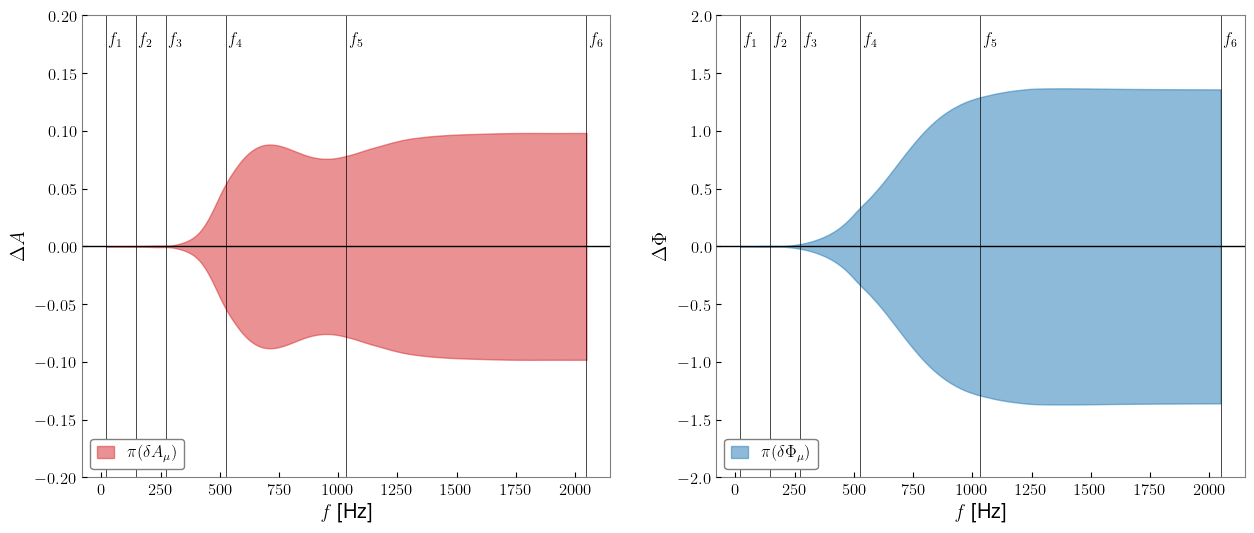

In [10]:
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].fill_between(frequency_grid,-amplitude_uncertainty,amplitude_uncertainty,color='tab:red',alpha=0.5,label=r'$\pi(\delta{A}_{\mu})$',zorder=1)
for i in range(len(frequency_nodes)):
    ax[0].axvline(frequency_nodes[i],color='k',linewidth=0.5)
    ax[0].annotate(r'$f_{val}$'.replace('val',str(i+1)),(frequency_nodes[i]+10,0.175))
ax[0].axhline(0,color='k',linewidth=1)
ax[0].legend(fancybox=True,loc='lower left',framealpha=1)
ax[0].set_ylim(-0.2,0.2)
ax[0].grid(False)
ax[0].set_xlabel(r"$\mathit{f}$ [Hz]")
ax[0].set_ylabel(r"$\Delta{A}$")
ax[0].tick_params(direction='in')

ax[1].fill_between(frequency_grid,-phase_uncertainty,phase_uncertainty,color='tab:blue',alpha=0.5,label=r'$\pi(\delta\Phi_{\mu})$',zorder=1)
for i in range(len(frequency_nodes)):
    ax[1].axvline(frequency_nodes[i],color='k',linewidth=0.5)
    ax[1].annotate(r'$f_{val}$'.replace('val',str(i+1)),(frequency_nodes[i]+10,1.75))
ax[1].axhline(0,color='k',linewidth=1)
ax[1].legend(fancybox=True,loc='lower left',framealpha=1)
ax[1].set_ylim(-2,2)
ax[1].grid(False)
ax[1].set_xlabel(r"$\mathit{f}$ [Hz]")
ax[1].set_ylabel(r"$\Delta\Phi$")
ax[1].tick_params(direction='in')

plt.show()